In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL as pl
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AvgPool2D, MaxPooling2D, Flatten, Dense, Dropout
import zipfile
import os

## 데이터 준비

In [3]:


import os

# 일반 폴더에서 불러오기

# Directory containing image files
img_dir = '/content/drive/MyDrive/부트캠프/프로젝트2/자료'

img_width = 128
img_height = 128

# Second section of the path
categories = ['편평세포암종', '선암종', '대세포암종', '정상']

# Create directories for extracted images
output_dir = '/content/img_data'
os.makedirs(output_dir, exist_ok=True)

# Extract images from the directories and store them in img_data folder
img_data = []
for idx, cata in enumerate(categories):
    folder = os.path.join(img_dir, cata)

    # Label for the current category
    label = idx

    # Check if the directory exists
    if os.path.exists(folder):
        # Check if images exist in the folder
        for img_file in os.listdir(folder):
            img_path = os.path.join(folder, img_file)
            try:
                # Attempt to read and resize the image
                img_array = cv2.imread(img_path)
                img_array = cv2.resize(img_array, (img_height, img_width))

                # Check if the image array is not empty
                if img_array is not None and not img_array.size == 0:
                    img_data.append([img_array, label])

            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue
    else:
        print(f"Folder {folder} does not exist.")

# Now img_data contains all the images from the specified directories along with their labels.


In [4]:
random.shuffle(img_data)

In [5]:
x=[]
y=[]
for features,labels in img_data:
    x.append(features)
    y.append(labels)

#Convert X and Y list into array
X=np.array(x, dtype = float)
Y=np.array(y, dtype = float)

In [6]:
print(X[19])

[[[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 ...

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]]


In [7]:
for i in range(len(X)):
    X[i] = X[i]/255.0

In [ ]:
X.shape

(1029, 128, 128, 3)

In [8]:
x, x_test, y, y_test = train_test_split(X, Y, test_size = 0.2)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2)

## 데이터 증강

In [10]:
# 데이터를 더 작게
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,      # Rotate the image by up to 15 degrees
    width_shift_range=0.1,  # Shift the image horizontally by up to 10% of the width
    height_shift_range=0.1, # Shift the image vertically by up to 10% of the height
    shear_range=0.1,        # Shear the image by up to 10 degrees
    zoom_range=0.1,         # Zoom in or out by up to 10%
    horizontal_flip=True,   # Flip the image horizontally
    fill_mode='nearest'     # Fill in missing pixels with the nearest value
)

# Define the number of augmented images to generate per original image
augmented_images_per_original = 6


# Define the batch size
batch_size = 4


# 전체 데이터를 두 개의 그룹으로 나눔
total_data = len(x_train)
split_index = total_data // 2
x_train_group1, x_train_group2 = x_train[:split_index], x_train[split_index:]
y_train_group1, y_train_group2 = y_train[:split_index], y_train[split_index:]

# 각 그룹에 대해 데이터 증강 적용 및 결합
x_train_augmented, y_train_augmented = [], []

for x_train_group, y_train_group in [(x_train_group1, y_train_group1), (x_train_group2, y_train_group2)]:
    for i in range(0, len(x_train_group), batch_size):
        batch_x = x_train_group[i:i+batch_size]
        batch_y = y_train_group[i:i+batch_size]

        # 각 배치에 대해 데이터 증강 적용
        augmented_x_batch, augmented_y_batch = [], []
        for j in range(len(batch_x)):
            for _ in range(augmented_images_per_original):
                augmented_image = datagen.flow(np.expand_dims(batch_x[j], axis=0), batch_size=1)[0][0]
                augmented_x_batch.append(augmented_image)
                augmented_y_batch.append(batch_y[j])

        x_train_augmented.extend(augmented_x_batch)
        y_train_augmented.extend(augmented_y_batch)

# 데이터 결합
x_train_augmented = np.array(x_train_augmented)
y_train_augmented = np.array(y_train_augmented)


In [ ]:
x_train_augmented.shape, type(x_train_augmented)

((3948, 128, 128, 3), numpy.ndarray)

### 세션종료 방지를 위한 넘파이 파일 저장

In [ ]:
# import numpy as np

# # 넘파이 배열 생성
# arr = x_train_augmented

# # save 함수를 사용하여 배열 저장
# np.save('x_array.npy', arr)

# y_train_augmented

# # 넘파이 배열 생성
# arr2 = y_train_augmented

# # save 함수를 사용하여 배열 저장
# np.save('y_array.npy', arr2)



### 저장한 넘파이 파일 불러오기

In [ ]:
# import numpy as np

# # 넘파이 파일 불러오기
# xx_train = np.load('x_array.npy')

# # 불러온 배열 확인
# print(x_train)

# # 넘파이 파일 불러오기
# yy_train = np.load('y_array.npy')

# # 불러온 배열 확인
# print(y_train)


## CNN

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(128, (3, 3), padding='same', input_shape=X.shape[1:], activation='relu'))
model.add(AveragePooling2D(2, 2))
model.add(Dropout(0.3))  # Dropout 추가
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))  # Dropout 추가
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))  # Dropout 추가
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5, seed=12))  # Dropout 비율 증가
model.add(Dense(3000, activation='relu'))
model.add(Dropout(0.5))  # Dropout 추가
model.add(Dense(1500, activation='relu'))
model.add(Dropout(0.5))  # Dropout 추가
model.add(Dense(4, activation='softmax'))  # 출력 층의 뉴런 수를 4로 변경

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 average_pooling2d (Average  (None, 64, 64, 128)       0         
 Pooling2D)                                                      
                                                                 
 dropout (Dropout)           (None, 64, 64, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                     

In [ ]:
# # Save the model
# model.save("lung_cancer_detection_model.h5")
# # Load the saved model
# from tensorflow.keras.models import load_model
# loaded_model = load_model("lung_cancer_detection_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 average_pooling2d (Average  (None, 64, 64, 128)       0         
 Pooling2D)                                                      
                                                                 
 dropout (Dropout)           (None, 64, 64, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                     

## 훈련

In [14]:
# 과적합 방지 조기종료 설정
# Import EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [15]:
# 훈련
history = model.fit(x_train, y_train, validation_data = (x_val, y_val),epochs = 45)

Epoch 1/45
21/21 [==============================] - 199s 9s/step - loss: 1.1401 - accuracy: 0.5365 - val_loss: 1.2381 - val_accuracy: 0.5697
Epoch 2/45
21/21 [==============================] - 194s 9s/step - loss: 0.7792 - accuracy: 0.5973 - val_loss: 0.7883 - val_accuracy: 0.7030
Epoch 3/45
21/21 [==============================] - 191s 9s/step - loss: 0.7669 - accuracy: 0.6702 - val_loss: 0.6815 - val_accuracy: 0.7333
Epoch 4/45
21/21 [==============================] - 182s 9s/step - loss: 0.6891 - accuracy: 0.7204 - val_loss: 0.6289 - val_accuracy: 0.7091
Epoch 5/45
21/21 [==============================] - 193s 9s/step - loss: 0.5708 - accuracy: 0.7371 - val_loss: 0.5735 - val_accuracy: 0.7879
Epoch 6/45
21/21 [==============================] - 191s 9s/step - loss: 0.5376 - accuracy: 0.7629 - val_loss: 0.5747 - val_accuracy: 0.7636
Epoch 7/45
21/21 [==============================] - 189s 9s/step - loss: 0.5566 - accuracy: 0.7660 - val_loss: 0.7788 - val_accuracy: 0.7758
Epoch 8/45
21

In [ ]:
# # Save the model
# model.save("lung_cancer_detection_model.h5")
# # Load the saved model
# from tensorflow.keras.models import load_model
# loaded_model = load_model("lung_cancer_detection_model.h5")

## 성능 평가

In [16]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

7/7 [==============================] - 15s 2s/step - loss: 0.4248 - accuracy: 0.8544
Test Loss: 0.4248178005218506
Test Accuracy: 0.8543689250946045


In [ ]:
plt.plot(history.history['accuracy'], label = 'Train accuracy')
plt.plot(history.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')

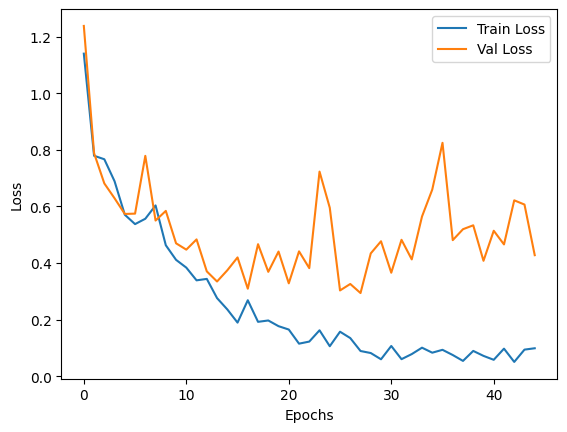

In [18]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'best')

레이블이 편향된 데이터라면
정상 9 불량 1인 데이터 --> 모두 정상으로 판단하면 정확률은 90% 즉 신뢰성이 없으므로 혼동 메트릭스를 사용해서 제1종오류 제2종오류에 대해서 측정해보고 의미파악하고 ROC_AOC 평가지표를 사용하고 사이킷런에 있는 classification_report도 사용해 보세요

규제알고리즘 dropout도 적용해보고

## 이미지 입력해보기

1/1 [==============================] - 0s 330ms/step
Predicted Class Label: 3
Confidence: 1.0
Predicted Category: normal


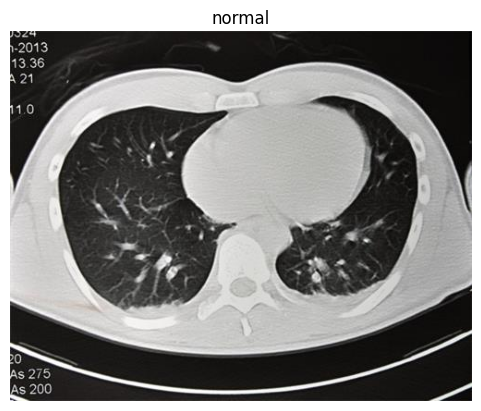

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the test image
image_path = '/content/drive/MyDrive/부트캠프/프로젝트2/test_image.jpg'
img = cv2.imread(image_path)

img = cv2.resize(img, (img_height, img_width))

# Expand dimensions to create a batch of size 1
img = np.expand_dims(img, axis=0)

# Make prediction
prediction = model.predict(img)

# Interpret prediction
class_label = np.argmax(prediction)
confidence = prediction[0][class_label]

print("Predicted Class Label:", class_label)
print("Confidence:", confidence)

# Mapping class labels to categories
class_labels_to_categories = {0: 'squamous cell carcinoma', 1: 'adenocarcinoma', 2: 'Large cell carcinoma', 3: 'normal'}
# ['편평세포암종', '선암종', '대세포암종', '정상']
# Display the predicted category
predicted_category = class_labels_to_categories[class_label]
print("Predicted Category:", predicted_category)

img = cv2.imread(image_path)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(predicted_category)
plt.show()

### 제1종오류, 2종오류 파악하기

In [23]:
result = model.predict(x_test)

7/7 [==============================] - 24s 3s/step


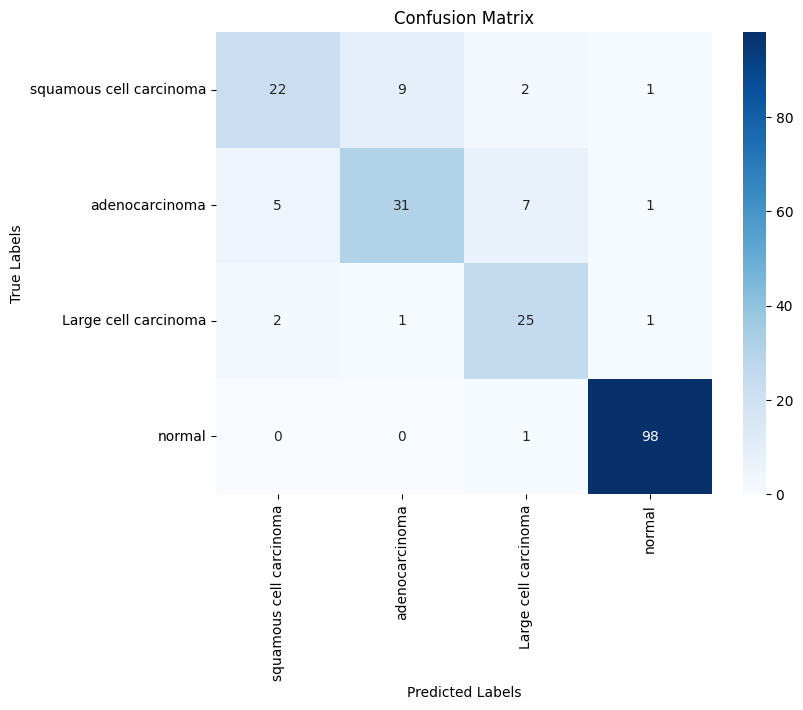

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define true labels and predicted labels
true_labels = y_test
predicted_labels = np.argmax(result, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels_to_categories.values(),
            yticklabels=class_labels_to_categories.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()